### `pip install --upgrade scikit-image`

`skimage.__version__` >= 14.0

In [1]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from numpy.fft import fftshift, fft2
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter, map_coordinates
from scipy.misc import imresize
from scipy.ndimage.filters import convolve as conv2
from scipy.ndimage.filters import convolve1d as conv1

from utils import rgb2gray, imnoise, add_gaussian_noise, gaussian2, affinefit

# CS-E4850 Computer Vision Exercise Round 3

## Exercise 3 - Image blending

Implement **Laplacian pyramid** blending and blends facial images of a wolf and a man. 

- Implement the generation procedure for Gaussian and Laplacian image pyramids and 
- Reconstruction procedure for reconstructing an image from its Laplacian pyramid.

In [2]:
man = imread('./assets/man_color.jpg') / 255.
man = resize(man, (int(man.shape[0] / 2), int(man.shape[1] / 2)))

wolf = imread('./assets/wolf_color.jpg') / 255.
wolf = resize(wolf, (int(wolf.shape[0] / 2), int(wolf.shape[1] / 2)))

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Image pyramid

### Gaussian Pyramid
1) Use two 1D convolutions with the binomial filter kernel  `g = [1 4 6 4 1]/16`

2) Downsample half the resolution ($\frac{1}{4}$ of the resolution)

Repeated convolutions of the binomial kernel converge to a Gaussian

In [3]:
levels = 9

im = man
im_copy = im.copy()
gaussian_pyramid = [im]

filter_kernel = 1/16 * np.array([1.0, 4.0, 6.0, 4.0, 1.0])


for i in range(levels-1):
    # 1st conv with binomial filter
    c1 = conv1(im_copy, filter_kernel, axis=0, mode="reflect")
    # 2nd conv with binomial filter
    low_pass = conv1(c1, filter_kernel, axis=1, mode="reflect")
    
    im_copy = resize(low_pass, (int(im_copy.shape[0] / 2), int(im_copy.shape[1] / 2)), anti_aliasing=False)
    gaussian_pyramid.append(im_copy)
    
len(gaussian_pyramid)

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


9

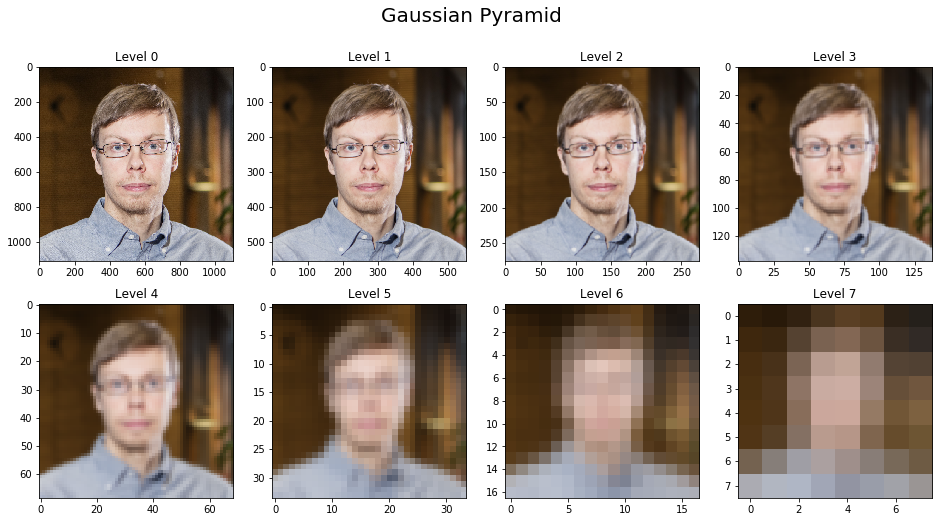

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
# ax = axes.ravel()

plt.suptitle("Gaussian Pyramid", fontsize=20)

for i in range(len(gaussian_pyramid)-1):
    sub_image = gaussian_pyramid[i]
    axes[int(i/4)][i%4].imshow(sub_image)
    axes[int(i/4)][i%4].set_title(f'Level {i}')

plt.show()

### Laplacian Pyramid

To construct this pyramid, we first blur and subsample the original image by a factor of two and store this in the next level of the pyramid

Interpolation in the reconstruction
procedure can be performed by 
- adding zeros between the rows and columns of the lower resolution image (use `skimage.transform.resize`)
- then filtering horizontally and vertically with the kernel 2g 

In [5]:
levels = 8

laplacian_pyramid = []

for i in range(levels):
    upscaled = resize(gaussian_pyramid[i+1], gaussian_pyramid[i].shape)
    upscaled = conv1(conv1(upscaled, filter_kernel, axis=0), filter_kernel, axis=1)
        
    difference = gaussian_pyramid[i] - upscaled
    laplacian_pyramid.append(difference)
    
len(laplacian_pyramid)

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


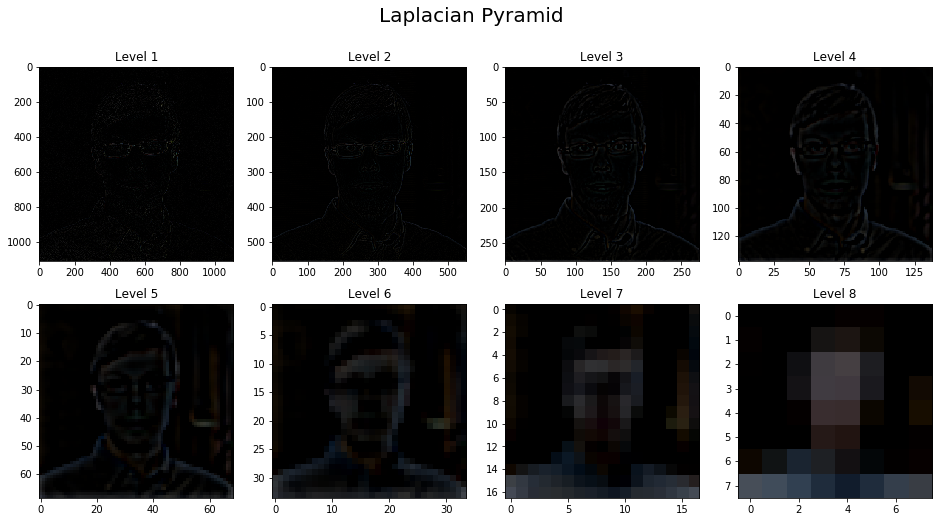

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

plt.suptitle("Laplacian Pyramid", fontsize=20)

for i in range(len(laplacian_pyramid)):
    sub_image = laplacian_pyramid[i]
    axes[int(i/4)][i%4].imshow(sub_image)
    axes[int(i/4)][i%4].set_title(f'Level {i+1}')

plt.show()

In [7]:
def generateLaplacianPyramid(im, ptype, levels):
    im_copy = im.copy()
    gaussian_pyramid = [im]
    laplacian_pyramid = []

    filter_kernel = 1/16 * np.array([1.0, 4.0, 6.0, 4.0, 1.0])

    for i in range(levels):
        # 1st conv with binomial filter
        c1 = conv1(im_copy, filter_kernel, axis=0, mode="reflect")
        # 2nd conv with binomial filter
        low_pass = conv1(c1, filter_kernel, axis=1, mode="reflect")

        im_copy = resize(low_pass, (int(im_copy.shape[0] / 2), int(im_copy.shape[1] / 2)), anti_aliasing=False)        
        gaussian_pyramid.append(im_copy)

    for i in range(levels):
        upscaled = resize(gaussian_pyramid[i+1], gaussian_pyramid[i].shape, anti_aliasing=False)
        upscaled = conv1(conv1(upscaled, filter_kernel, axis=0), filter_kernel, axis=1)
        difference = gaussian_pyramid[i] - upscaled
        laplacian_pyramid.append(difference)
    
    if ptype == 'gaussian':
        return gaussian_pyramid[:-1]
    elif ptype == 'laplacian':
        return laplacian_pyramid
    else:
        raise ValueError('Unknown pyramid type: ' + str(ptype))

### Reconstructing image from laplacian pyramid

In [8]:
# resconstruction over here
lp = generateLaplacianPyramid(man, 'laplacian', levels=8)

for image in lp:
    print(image.shape)

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1106, 1106, 3)
(553, 553, 3)
(276, 276, 3)
(138, 138, 3)
(69, 69, 3)
(34, 34, 3)
(17, 17, 3)
(8, 8, 3)


In [9]:
image = lp[0]

filter_kernel = 1/16 * np.array([1.0, 4.0, 6.0, 4.0, 1.0])

shape = image.shape[0:2]
shape

(1106, 1106)

In [10]:
for i in range(1, len(lp)):
    current_image = lp[i]
    resized_image = resize(current_image, shape, mode='reflect')
    
    c1 = conv1(resized_image, filter_kernel, axis=0)
    c2 = conv1(c1, filter_kernel, axis=1)
    image += c2

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


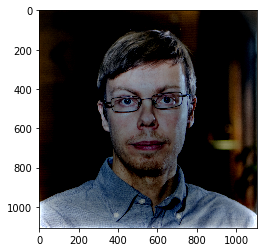

In [11]:
plt.imshow(image)

Interpolation in the reconstruction
procedure can be performed by adding zeros between the rows and columns of the lower
resolution image using Matlab function upsample and then filtering horizontally and
vertically with the kernel 2g as mentioned i

In [12]:
def reconstLaplacianPyramid(lpyramid):
    image = lpyramid[0][:]
    shape = image.shape[0:2]    
    filter_kernel = 1/16 * np.array([1.0, 4.0, 6.0, 4.0, 1.0])

    for i in range(1, len(lpyramid)):
        current_image = lpyramid[i]
        resized_image = resize(current_image, shape, mode='reflect')

        c1 = conv1(resized_image, filter_kernel, axis=0)
        c2 = conv1(c1, filter_kernel, axis=1)
        image += c2    
    
    return image

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


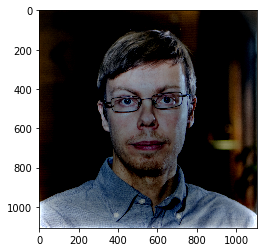

In [13]:
lp = generateLaplacianPyramid(man, ptype='laplacian', levels=8)

plt.imshow(reconstLaplacianPyramid(lp))

In [14]:
## Notice that in this implementation the first level of a Gaussian pyramid 
## is the original image, and the last level of a Laplacian pyramid is the
## same as the corresponding level in the Gaussian pyramid.

man = imread('./assets/man_color.jpg') / 255.
man = resize(man, (int(man.shape[0] / 2), int(man.shape[1] / 2)))

wolf = imread('./assets/wolf_color.jpg') / 255.
wolf = resize(wolf, (int(wolf.shape[0] / 2), int(wolf.shape[1] / 2)))

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [15]:
# the pixel coordinates of eyes and chin have been manually found 
# from both images in order to enable affine alignment 
man_eyes_chin=np.array([[452, 461], [652, 457], [554, 823]])
wolf_eyes_chin=np.array([[851, 919], [1159, 947], [975, 1451]])
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)         

xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size, 1)).T

wolft = np.zeros(man.shape)

for ch in range(3):
    wolft[:,:,ch] = map_coordinates(wolf[:,:,ch], (pt[1, :].reshape(man.shape[:2]),
                               pt[0, :].reshape(man.shape[:2]))) 

In [17]:
## Manually defined binary mask with an elliptical shape is constructed
## as well as its complement
x0=553.
y0=680.
a=160. 
b=190.
pixmask = (((xv-x0) / a) ** 2 + ((yv-y0) / b) ** 2) < 1

maskb = np.zeros(man.shape)
maskbw = np.zeros(man.shape[:2])
maskbw[pixmask] = 1.0
for c in range(3):
     maskb[:, :, c] = maskbw
maska = 1.0 - maskb

imga = resize(man, (1024,1024))
imgb = resize(wolft, (1024, 1024))
maska = resize(maska, (1024, 1024))
maskb = resize(maskb, (1024, 1024))    

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [18]:
level = 8
 
## Make Laplacian image pyramids with 8 levels.
## Output is cell array (i.e. lpimga{i} is the Laplacian image at level i).
## The image at the final level is the base level image from the
## corresponding Gaussian pyramid.
## In the version below the second input is either 'laplacian' or 'gaussian',
## and it defines whether to output Laplacian or Gaussian pyramid.
## After you have implemented the functions above you can uncomment the lines below
## to finally plot the lacking figures ('Pyramid Blending' and 'Difference')
lpimga = generateLaplacianPyramid(imga,'laplacian',level);
lpimgb = generateLaplacianPyramid(imgb,'laplacian',level);

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [19]:
## Just check that your pyramid and reconstruction both work
ima = reconstLaplacianPyramid(lpimga)
max_reconstruction_error = np.amax(np.abs(imga.flatten() - ima.flatten()))
print("Reconstruction error: {}".format(max_reconstruction_error))

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Reconstruction error: 0.8753998213772441


/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


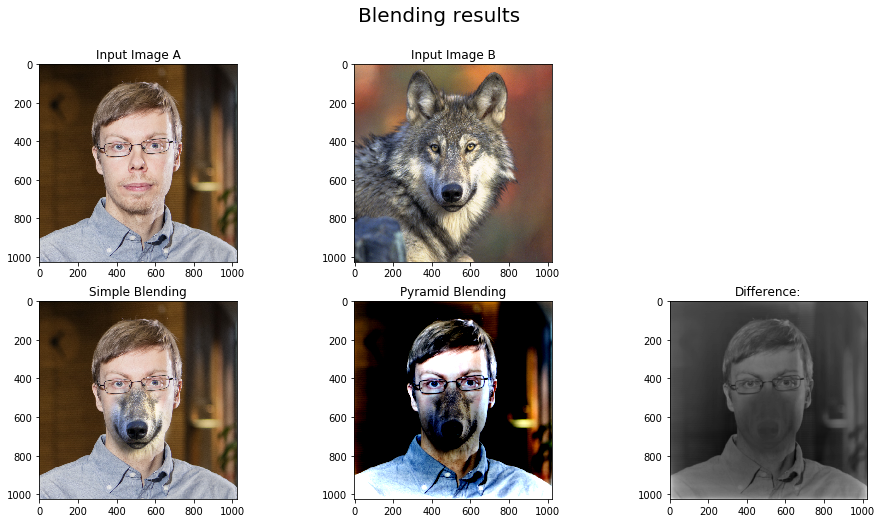

In [20]:
## Make Gaussian image pyramids of the mask images, maska and maskb
gpmaska = generateLaplacianPyramid(maska,'gaussian',level);
gpmaskb = generateLaplacianPyramid(maskb,'gaussian',level);

# Make smooth masks in a simple manner for comparison
smaska = gaussian_filter(maska, 20)
smaskb = gaussian_filter(maskb, 20)

## In practice, you can also use the Gaussian pyramids of smoothed masks. 
## In this case, the blendings (simple & pyramid) will appear more similar.
gpsmaska = generateLaplacianPyramid(smaska,'gaussian',level); 
gpsmaskb = generateLaplacianPyramid(smaskb,'gaussian',level);

limgo = {} # the blended pyramid
for p in range(level):
#    # Blend the Laplacian images at each level
#    # (You can use either one of the two rows below.)
#    limgo[p] = (lpimga[p]*gpmaska[p] + lpimgb[p]*gpmaskb[p])/(gpmaska[p]+gpmaskb[p])
   limgo[p] = (lpimga[p]*gpsmaska[p] + lpimgb[p]*gpsmaskb[p])/(gpsmaska[p]+gpsmaskb[p])

## Reconstruct the blended image from its Laplacian pyramid
imgo = reconstLaplacianPyramid(limgo);

## Simple blending with smooth masks
imgo1 = smaska*imga + smaskb*imgb

## Display results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
plt.suptitle("Blending results", fontsize=20)
ax = axes.ravel()
ax[0].imshow(imga, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(imgb, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].set_visible(False)
ax[3].imshow(imgo1, cmap='gray')
ax[3].set_title("Simple Blending")
ax[4].imshow(imgo, cmap='gray')
ax[4].set_title("Pyramid Blending")
ax[5].imshow(np.amax(imgo-imgo1, axis=2), cmap='gray')
ax[5].set_title("Difference:")
plt.show()

# Using skimage API for building pyramids

### Using `skimage.transform.pyramid_gaussian`

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


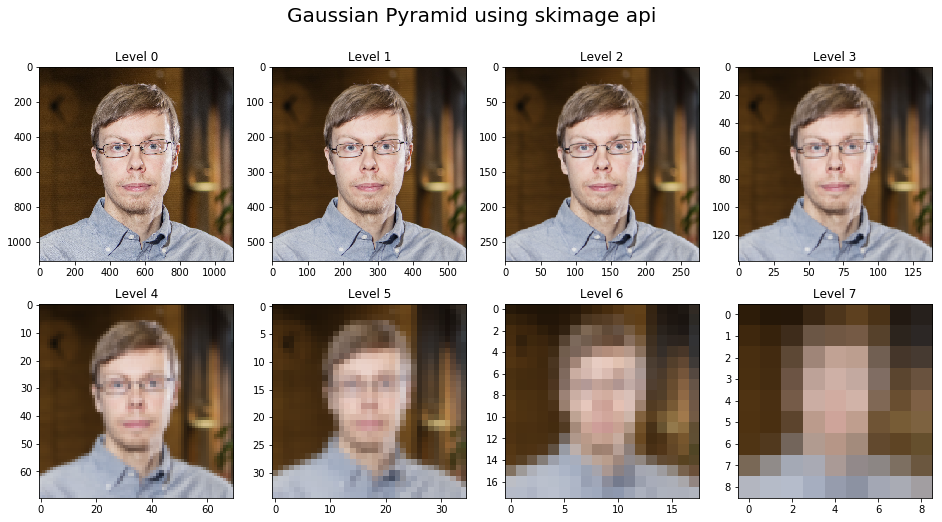

In [21]:
from skimage.transform import pyramid_gaussian

gp = list(pyramid_gaussian(image=man, max_layer=7)) # original image is layer 0

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
# ax = axes.ravel()

plt.suptitle("Gaussian Pyramid using skimage api", fontsize=20)

for i in range(len(gp)):
    sub_image = gp[i]
    axes[int(i/4)][i%4].imshow(sub_image)
    axes[int(i/4)][i%4].set_title(f'Level {i}')

plt.show()

### Using `skimage.transform.pyramid_laplacian`

`layer = resize(prev_layer) - smooth(resize(prev_layer))`

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Cli

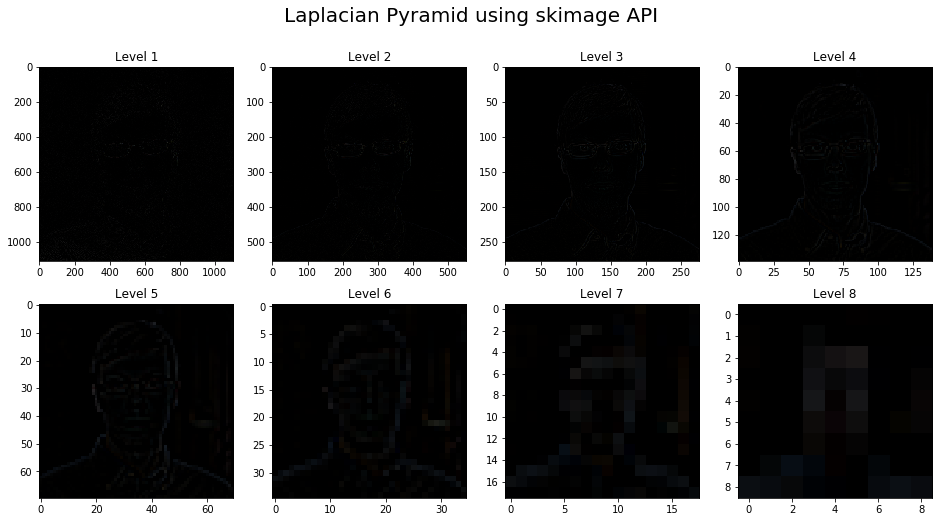

In [22]:
from skimage.transform import pyramid_laplacian

lp = list(pyramid_laplacian(man, max_layer=7))

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

plt.suptitle("Laplacian Pyramid using skimage API", fontsize=20)

for i in range(len(lp)):
    sub_image = lp[i]
    axes[int(i/4)][i%4].imshow(sub_image)
    axes[int(i/4)][i%4].set_title(f'Level {i+1}')

plt.show()